`April 6, 2022`

### **Ensemble Learning Exercise**

**Use 'Titanic' dataset.**

* Explore how each feature correlated with the probability of survival. Do EDA along with the interpretation of each feature.

* Do data preprocessing as needed (features selection included if needed).

* Which evaluation metrics do you use? Why?

* Use classifier algorithms you have learned so far, compare their performance and choose the best two. 

* Do hyperparameter tuning of the two selected models and pick the best one after testing on the test set.

* Create a conclusion or summary about what you have done.

* Use pipeline for the end-to-end process.

<hr>

### **Import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import category_encoders as ce

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, classification_report, accuracy_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

### **Explore & preprocess the data**

In [2]:
# Load dataset
titanic = pd.read_csv('titanic.csv')
titanic

,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...
886,male,27.0,0,13.0000,Second,NaN,Southampton,no,True
887,female,19.0,0,30.0000,First,B,Southampton,yes,True
888,female,NaN,2,23.4500,Third,NaN,Southampton,no,False
889,male,26.0,0,30.0000,First,C,Cherbourg,yes,True


In [3]:
# Check target class proportion
titanic['alive'].value_counts(True)*100

no     61.616162
yes    38.383838
Name: alive, dtype: float64

In [4]:
# Check shape of DataFrame
titanic.shape

(891, 9)

In [5]:
# Identify a single value in columns
titanic.nunique()

sex              2
age             88
parch            7
fare           248
class            3
deck             7
embark_town      3
alive            2
alone            2
dtype: int64

In [6]:
# Numerical features description
titanic.describe()

,age,parch,fare
count,714.000000,891.000000,891.000000
mean,29.699118,0.381594,32.204208
std,14.526497,0.806057,49.693429
min,0.420000,0.000000,0.000000
25%,20.125000,0.000000,7.910400
50%,28.000000,0.000000,14.454200
75%,38.000000,0.000000,31.000000
max,80.000000,6.000000,512.329200


In [7]:
# Categorical features description
titanic.describe(include='object')

,sex,class,deck,embark_town,alive
count,891,891,203,889,891
unique,2,3,7,3,2
top,male,Third,C,Southampton,no
freq,577,491,59,644,549


In [8]:
# if there is any missing values
titanic.isnull().sum()

sex              0
age            177
parch            0
fare             0
class            0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

>Age, deck, and embark_town columns contain missing values. The 'age' column will be imputed according to their respective gender and class median age. For the 'embark_town' column, the most frequent value will be used for imputing the missing values. On the other hand, the 'deck' column will be dropped since it has more than 50% of missing values.

`Age`

In [9]:
# Check missing values in the 'age' column
titanic[titanic['age'].isna() == True]

,sex,age,parch,fare,class,deck,embark_town,alive,alone
5,male,NaN,0,8.4583,Third,NaN,Queenstown,no,True
17,male,NaN,0,13.0000,Second,NaN,Southampton,yes,True
19,female,NaN,0,7.2250,Third,NaN,Cherbourg,yes,True
26,male,NaN,0,7.2250,Third,NaN,Cherbourg,no,True
28,female,NaN,0,7.8792,Third,NaN,Queenstown,yes,True
...,...,...,...,...,...,...,...,...,...
859,male,NaN,0,7.2292,Third,NaN,Cherbourg,no,True
863,female,NaN,2,69.5500,Third,NaN,Southampton,no,False
868,male,NaN,0,9.5000,Third,NaN,Southampton,no,True
878,male,NaN,0,7.8958,Third,NaN,Southampton,no,True


In [10]:
# Grouping by sex and class to get the median age
titanic.groupby(['sex', 'class']).median()['age']

sex     class 
female  First     35.0
        Second    28.0
        Third     21.5
male    First     40.0
        Second    30.0
        Third     25.0
Name: age, dtype: float64

In [11]:
# Impute missing values in the 'age' column according to their respective gender and class median age
titanic['age'] = titanic['age'].fillna(titanic.groupby(['sex', 'class'])['age'].transform('median'))

In [12]:
# Recheck the sum of missing values in the 'age' column
titanic.isna().sum()['age']

0

In [13]:
# Pick a random row that previously has missing value in the 'age' column to check the imputation result
titanic.iloc[[5]]

,sex,age,parch,fare,class,deck,embark_town,alive,alone
5,male,25.0,0,8.4583,Third,NaN,Queenstown,no,True


`Embark Town`

In [14]:
# Imputing 'embark_town' with mode value
titanic['embark_town'] = titanic['embark_town'].fillna(titanic['embark_town'].mode()[0])

`Deck`

In [15]:
# Drop 'deck' column
titanic.drop(columns=['deck'], axis=1, inplace=True)

### **EDA**

#### **Sex**

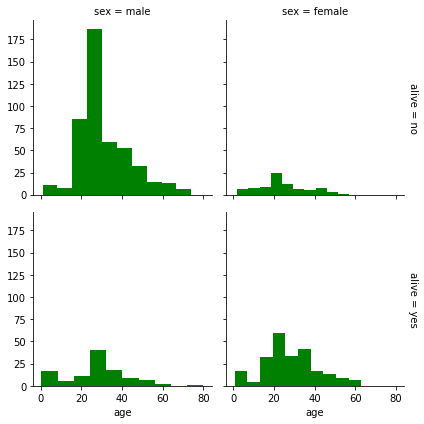

In [16]:
# Plot distribution of age and gender-related to survivability
sex_alive = sns.FacetGrid(titanic, col='sex', row='alive', margin_titles=True)
sex_alive.map(plt.hist, 'age', color= 'green')
plt.show()

>According to gender, the number of female passengers that survived is significantly greater than male passengers with the range of age 18 to 38 y.o.

#### **Age**

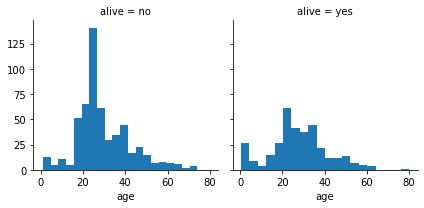

In [17]:
# Distribution plot of age vs survivability
age_alive = sns.FacetGrid(titanic, col='alive')
age_alive.map(plt.hist, 'age', bins=20)
plt.show()

#### **Class and Fare**

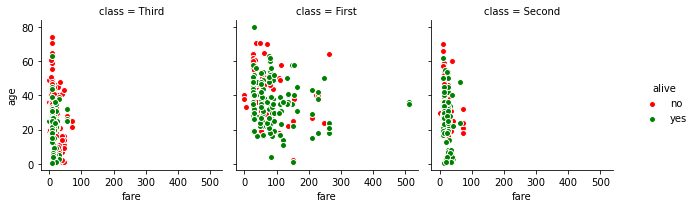

In [18]:
# Class & fare vs surviability
class_fare = sns.FacetGrid(titanic, hue='alive', col='class', margin_titles=True, palette={'yes':'green', 'no':'red'})
class_fare.map(plt.scatter, 'fare', 'age', edgecolor='w').add_legend()
plt.show()

In [19]:
titanic.groupby('class')['alive'].value_counts()

class   alive
First   yes      136
        no        80
Second  no        97
        yes       87
Third   no       372
        yes      119
Name: alive, dtype: int64

In [20]:
titanic.groupby('class')['alive'].value_counts()/titanic.shape[0]*100

class   alive
First   yes      15.263749
        no        8.978676
Second  no       10.886644
        yes       9.764310
Third   no       41.750842
        yes      13.355780
Name: alive, dtype: float64

>- Most of the passengers are in the third class.
>- Most of the survived passengers come from the first class (15%), followed by the third class (13%).

#### **Age, Gender, Fare**

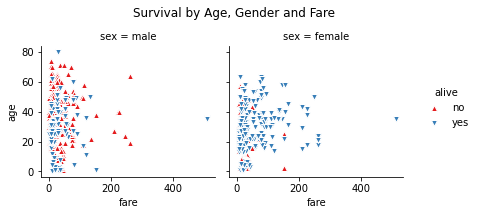

In [21]:
# Age, gender, fare vs survivability
age_gender_fare = sns.FacetGrid(titanic, hue='alive', col='sex', margin_titles=True, palette='Set1', hue_kws=dict(marker=['^', 'v']))
age_gender_fare.map(plt.scatter, 'fare', 'age',edgecolor='w').add_legend()
plt.subplots_adjust(top=0.8)
age_gender_fare.fig.suptitle('Survival by Age, Gender and Fare')
plt.show()

In [22]:
titanic.groupby('sex')['alive'].value_counts()

sex     alive
female  yes      233
        no        81
male    no       468
        yes      109
Name: alive, dtype: int64

In [23]:
titanic.groupby('sex')['alive'].value_counts()/titanic.shape[0]*100

sex     alive
female  yes      26.150393
        no        9.090909
male    no       52.525253
        yes      12.233446
Name: alive, dtype: float64

>- The number of female passengers who survived is two-fold greater than the number of male passengers who survived.
>- More than 50% of total passengers that are not survived are male passengers.

#### **Embark Town**

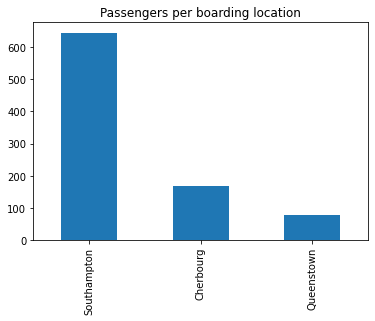

In [24]:
# The frequency of embark_town
titanic.embark_town.value_counts().plot(kind='bar')
plt.title('Passengers per boarding location')
plt.show()

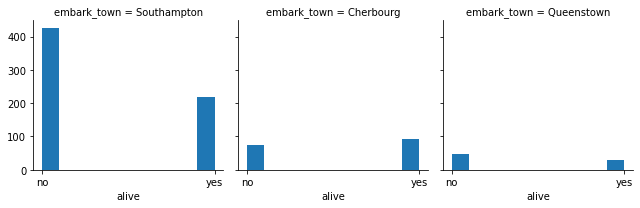

In [25]:
# Embark town vs survivability
embark_alive = sns.FacetGrid(titanic, col='embark_town')
embark_alive.map(plt.hist, 'alive')
plt.show()

In [26]:
# Ratio in number
titanic.groupby('embark_town')['alive'].value_counts()

embark_town  alive
Cherbourg    yes       93
             no        75
Queenstown   no        47
             yes       30
Southampton  no       427
             yes      219
Name: alive, dtype: int64

In [27]:
# Ratio in percentage
titanic.groupby('embark_town')['alive'].value_counts()/titanic.shape[0]*100

embark_town  alive
Cherbourg    yes      10.437710
             no        8.417508
Queenstown   no        5.274972
             yes       3.367003
Southampton  no       47.923681
             yes      24.579125
Name: alive, dtype: float64

#### **Embark Town and Class**

In [28]:
# Ratio in number
titanic.groupby('embark_town')['class'].value_counts()

embark_town  class 
Cherbourg    First      85
             Third      66
             Second     17
Queenstown   Third      72
             Second      3
             First       2
Southampton  Third     353
             Second    164
             First     129
Name: class, dtype: int64

In [29]:
# Ratio in percentage
titanic.groupby('embark_town')['class'].value_counts()/titanic.shape[0]*100

embark_town  class 
Cherbourg    First      9.539843
             Third      7.407407
             Second     1.907969
Queenstown   Third      8.080808
             Second     0.336700
             First      0.224467
Southampton  Third     39.618406
             Second    18.406285
             First     14.478114
Name: class, dtype: float64

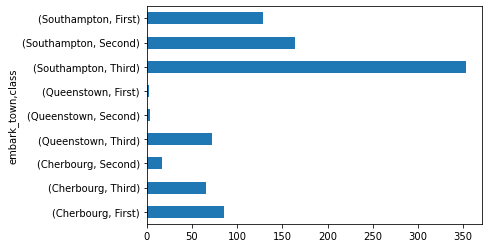

In [30]:
# Plot ratio in number
titanic.groupby('embark_town')['class'].value_counts().plot(kind='barh');

>- Most of the passengers embarked from Southampton (> 70%).
>- However, only Cherbourg has a higher ratio of the number of survivors. This may be because the passengers from Cherbourg were first-class passengers, which probably took precedence when the disaster occurred.

#### **Alone**

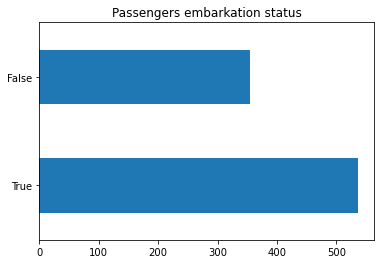

In [31]:
# Count of passengers who survived according to the embarkation status
titanic.alone.value_counts().plot(kind='barh')
plt.title('Passengers embarkation status')
plt.show()

In [32]:
# Ratio in number of embarkation status (alone) and survivability
titanic.groupby('alone')['alive'].value_counts()

alone  alive
False  yes      179
       no       175
True   no       374
       yes      163
Name: alive, dtype: int64

In [33]:
# Ratio in number of class and survivability
titanic.groupby('alone')['class'].value_counts()

alone  class 
False  Third     167
       First     107
       Second     80
True   Third     324
       First     109
       Second    104
Name: class, dtype: int64

>The passengers traveling alone are more likely not to survive. It may be correlated with the fact that most passengers who depart alone are third-class passengers.

### **Preprocessing schemas**

In [34]:
num_features = [feature for feature in titanic.columns if ((titanic[feature].dtypes != 'O'))]
num_features

['age', 'parch', 'fare', 'alone']

In [35]:
cat_features = [feature for feature in titanic.columns if (titanic[feature].dtypes == 'O')]
cat_features

['sex', 'class', 'embark_town', 'alive']

In [36]:
# Change the columns order
cols = num_features + cat_features
titanic = titanic[cols]
titanic.head()

,age,parch,fare,alone,sex,class,embark_town,alive
0,22.0,0,7.2500,False,male,Third,Southampton,no
1,38.0,0,71.2833,False,female,First,Cherbourg,yes
2,26.0,0,7.9250,True,female,Third,Southampton,yes
3,35.0,0,53.1000,False,female,First,Southampton,yes
4,35.0,0,8.0500,True,male,Third,Southampton,no


In [37]:
# Mapping for the 'class' column
ordinal_mapping= [
    {'col':'class',
    'mapping': {None:0, 'First':3, 'Second':2, 'Third':1}}]
ordinal_encoder = ce.OrdinalEncoder(cols = 'class', mapping=ordinal_mapping)

In [38]:
titanic.head()

,age,parch,fare,alone,sex,class,embark_town,alive
0,22.0,0,7.2500,False,male,Third,Southampton,no
1,38.0,0,71.2833,False,female,First,Cherbourg,yes
2,26.0,0,7.9250,True,female,Third,Southampton,yes
3,35.0,0,53.1000,False,female,First,Southampton,yes
4,35.0,0,8.0500,True,male,Third,Southampton,no


In [39]:
# Transformer
transformer = ColumnTransformer([
    ('one hot encoder', OneHotEncoder(drop='first'), ['sex', 'alone', 'embark_town']),
    ('ordinal encoding', ordinal_encoder, ['class']),
    ('scaler', RobustScaler(), ['age', 'fare'])
], remainder='passthrough')

### **Data splitting**

In [40]:
X = titanic.drop(columns = ['alive', 'parch'])
y = np.where(titanic['alive'] == 'yes', 1, 0)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.3,
    stratify = y,
    random_state = 42)

### **Data transformation**

`These steps in this part are unnecessary if you do the modeling with a pipeline. This part is to remind you how to generate the feature names after encoding.`

In [42]:
X_train_prep = transformer.fit_transform(X_train)
X_test_prep = transformer.transform(X_test)

In [43]:
X_train_prep = pd.DataFrame(X_train_prep)
X_test_prep = pd.DataFrame(X_test_prep)

In [44]:
transformer.transformers_

[('one hot encoder',
  OneHotEncoder(drop='first'),
  ['sex', 'alone', 'embark_town']),
 ('ordinal encoding',
  OrdinalEncoder(cols=['class'],
                 mapping=[{'col': 'class',
                           'mapping': {None: 0, 'First': 3, 'Second': 2,
                                       'Third': 1}}]),
  ['class']),
 ('scaler', RobustScaler(), ['age', 'fare'])]

In [45]:
transformer.transformers_[0][1].get_feature_names()

array(['x0_male', 'x1_True', 'x2_Queenstown', 'x2_Southampton'],
      dtype=object)

In [46]:
transformer.transformers_[1][1].get_feature_names()

['class']

In [47]:
features = list(transformer. transformers_[0][1].get_feature_names()) + transformer.transformers_[1][1].get_feature_names() + ['age', 'fare']
X_train_prep.columns = features
X_test_prep.columns = features
X_train_prep

,x0_male,x1_True,x2_Queenstown,x2_Southampton,class,age,fare
0,1.0,0.0,0.0,1.0,3.0,-0.43750,1.791515
1,1.0,1.0,0.0,1.0,1.0,-0.06250,-0.246559
2,0.0,1.0,1.0,0.0,1.0,-0.28125,-0.254287
3,1.0,1.0,0.0,1.0,3.0,0.87500,-0.610744
4,1.0,0.0,0.0,1.0,1.0,0.12500,0.106315
...,...,...,...,...,...,...,...
618,1.0,0.0,0.0,1.0,2.0,0.50000,0.339302
619,0.0,1.0,0.0,1.0,2.0,0.37500,-0.022620
620,0.0,0.0,0.0,1.0,1.0,1.37500,0.944391
621,1.0,1.0,0.0,1.0,3.0,1.31250,1.131007


### **Models performance**

In [48]:
# Define models
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=42)
logreg = LogisticRegression(random_state=42, max_iter=1000)
rf = RandomForestClassifier(random_state=42)

models_voting = [
    ('knn', knn),
    ('dt', tree),
    ('logreg', logreg),
    ('rf', rf)
    ]
    
soft_voting = VotingClassifier(models_voting, voting='soft', n_jobs=-1)
bagging = BaggingClassifier(logreg, random_state=42)

# Define end-to-end pipeline
models = [knn, tree, logreg, rf, soft_voting, bagging]
score = []
mean_score = []
std_score = []

for i in models:
    smotenc = SMOTENC(categorical_features=np.array(range(3, 6)), random_state=42)
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    estimator = Pipeline([
        ('resampling', smotenc),
        ('preprocessing', transformer),
        ('model', i)
    ])

    model_cv = cross_val_score(estimator, X_train, y_train, cv=skfold, scoring='f1', error_score='raise')
    score.append(model_cv)
    mean_score.append(model_cv.mean())
    std_score.append(model_cv.std())

In [49]:
pd.DataFrame({
    'Model':['KNN', 'Decision Tree', 'Logistic regression', 'Random forest', 'Soft Voting', 'Bagging Logreg'],
    'F1 score mean': mean_score,
    'F1 score std': std_score
})

,Model,F1 score mean,F1 score std
0,KNN,0.713004,0.033826
1,Decision Tree,0.693019,0.028015
2,Logistic regression,0.726672,0.037219
3,Random forest,0.746241,0.025589
4,Soft Voting,0.750393,0.031403
5,Bagging Logreg,0.727293,0.034482


>According to the table above, random forest and logistic regression models have the highest F1 score mean. One thing to note is that the bagging logreg is slightly more stable than logistic regression. However, that discrepancy on the std value would not affect much, considering their mean scores are tight. Thus, we can go with the random forest and logistic regression models for the next steps.

### **Model performance on test set**

In [50]:
rf = RandomForestClassifier(random_state=42)
logreg = LogisticRegression(random_state=42, max_iter=1000)

models = [rf, logreg]
score = []

for i in models:
    smotenc = SMOTENC(categorical_features=np.array(range(3, 6)), random_state=42)
    estimator = Pipeline([
        ('resampling', smotenc),
        ('preprocessing', transformer),
        ('model', i)
    ])

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    score.append([f1_score(y_test, y_pred)])

score_before_tuning = pd.DataFrame(score, columns=['F1 score'], index = ['Random Forest', 'Logistic Regression'])
score_before_tuning

,F1 score
Random Forest,0.728205
Logistic Regression,0.747748


### **Hyperparamater tuning**

In [51]:
# Create the algorithm chains
smotenc = SMOTENC(categorical_features=np.array(range(3, 6)), random_state=42)
skfold = StratifiedKFold(n_splits=5)
estimator_rf = Pipeline([('preprocessing', transformer), ('balancing', smotenc), ('clf_rf', rf)])
estimator_logreg = Pipeline([('preprocessing', transformer), ('balancing', smotenc), ('clf_logreg', logreg)])

# Random forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 12, num = 10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

hyperparam_space_rf = {
    'clf_rf__n_estimators': n_estimators,
    'clf_rf__max_features': max_features,
    'clf_rf__max_depth': max_depth,
    'clf_rf__min_samples_split': min_samples_split,
    'clf_rf__min_samples_leaf': min_samples_leaf,
    'clf_rf__bootstrap': bootstrap
}

# Logistic Regression
hyperparam_space_logreg = {
    'clf_logreg__C': [1000, 500, 100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
    'clf_logreg__solver': ['liblinear', 'newton-cg', 'lbfgs'],
    'clf_logreg__max_iter': [100, 200, 300, 400, 500, 1000]

}

# Randomized search
random_rf = RandomizedSearchCV(
    estimator_rf, 
    param_distributions = hyperparam_space_rf,
    cv = skfold,
    scoring= 'f1',
    n_jobs= -1
)

random_logreg = RandomizedSearchCV(
    estimator_logreg,
    param_distributions = hyperparam_space_logreg,
    cv = skfold,
    scoring= 'f1',
    n_jobs= -1
)

In [52]:
random_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one '
                                                                               'hot '
                                                                               'encoder',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['sex',
                                                                                'alone',
                                                                                'embark_town']),
                                                                              ('ordinal '
                              

In [53]:
random_logreg.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one '
                                                                               'hot '
                                                                               'encoder',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['sex',
                                                                                'alone',
                                                                                'embark_town']),
                                                                              ('ordinal '
                              

In [54]:
print('Best score random forest:', random_rf.best_score_)
print('Best params random forest:', random_rf.best_params_)
print()
print('Best score logistic regression:', random_logreg.best_score_)
print('Best params logistic regression:', random_logreg.best_params_)

Best score random forest: 0.7695594668118891
Best params random forest: {'clf_rf__n_estimators': 200, 'clf_rf__min_samples_split': 10, 'clf_rf__min_samples_leaf': 1, 'clf_rf__max_features': 'sqrt', 'clf_rf__max_depth': 7, 'clf_rf__bootstrap': False}

Best score logistic regression: 0.7369715967010766
Best params logistic regression: {'clf_logreg__solver': 'newton-cg', 'clf_logreg__max_iter': 500, 'clf_logreg__C': 10}


### **Model performance after tuning**

In [55]:
# Fit to the best estimator
rf_tuning = random_rf.best_estimator_
rf_tuning.fit(X_train, y_train)

logreg_tuning = random_logreg.best_estimator_
logreg_tuning.fit(X_train, y_train)

y_pred_rf_tuning = rf_tuning.predict(X_test)
y_pred_logreg_tuning = logreg_tuning.predict(X_test)

f1_rf_tuning = f1_score(y_test, y_pred_rf_tuning)
f1_logreg_tuning = f1_score(y_test, y_pred_logreg_tuning)


In [56]:
score_list = [f1_rf_tuning, f1_logreg_tuning]
models = ['Random Forest', 'Logistic Regression'] 

score_after_tuning = pd.DataFrame({
    'Model': models,
    'F1 score': score_list
})

### **Comparison of the F1 scores**

In [57]:
score_before_tuning

,F1 score
Random Forest,0.728205
Logistic Regression,0.747748


In [58]:
score_after_tuning

,Model,F1 score
0,Random Forest,0.764706
1,Logistic Regression,0.736842


### **Conclusion**

1. The most optimum model to predict passengers' survivability of titanic collision according to the F1 score is the random forest with hyperparameter tuning.
2. Hyperparameter tuning process causes the F1 score of random forest and logistic regression increases. However, the random forest can outperform logistic regression at the end, even though the score is not so different.

<hr>

*Note: The interpretation was made for the modeling version without scaling.*